In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/philip/DIKU/bachelor_project/


### Imports

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import time

from data.tinyimagenet import TinyImageNet

from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.eval_tools import load_and_eval_mls_osr_for_all_eps
from our_modules.eval_tools import max_logit_change_compared_id_vs_ood

from our_modules.plot_tools import plot_roc
from our_modules.plot_tools import plot_image
from our_modules.plot_tools import plot_image_on_ax

from our_modules.tin_tools import test_transform as tin_test_transform
from our_modules.tin_tools import mean as tin_mean, std as tin_std
from our_modules.tin_tools import get_model_for_split
from our_modules.tin_tools import transform_range as tin_transform_range

from our_modules.adv_tools import fn_osr_fgsm


### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


# Tinyimagenet

In [5]:
tin_dataset = TinyImageNet(root_dir + 'datasets/tiny-imagenet-200/val/images/', transform=tin_test_transform)
tin_goldfish = tin_dataset[9][0]

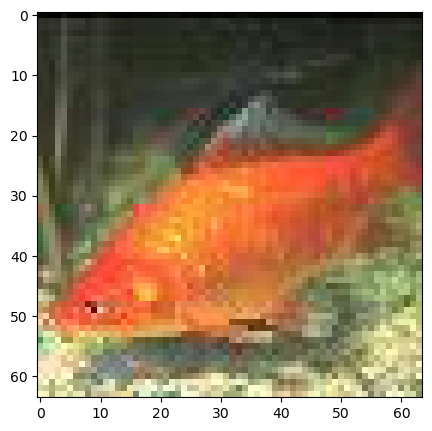

In [6]:
plot_image(tin_goldfish, tin_mean, tin_std)

### FN

#### FGSM with varying epsilon values

In [7]:
eps, roc_stats = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fn/fgsm/', 0, dataset_name='tinyimagenet', balance=True)
aurocs = [x[1] for x in roc_stats]

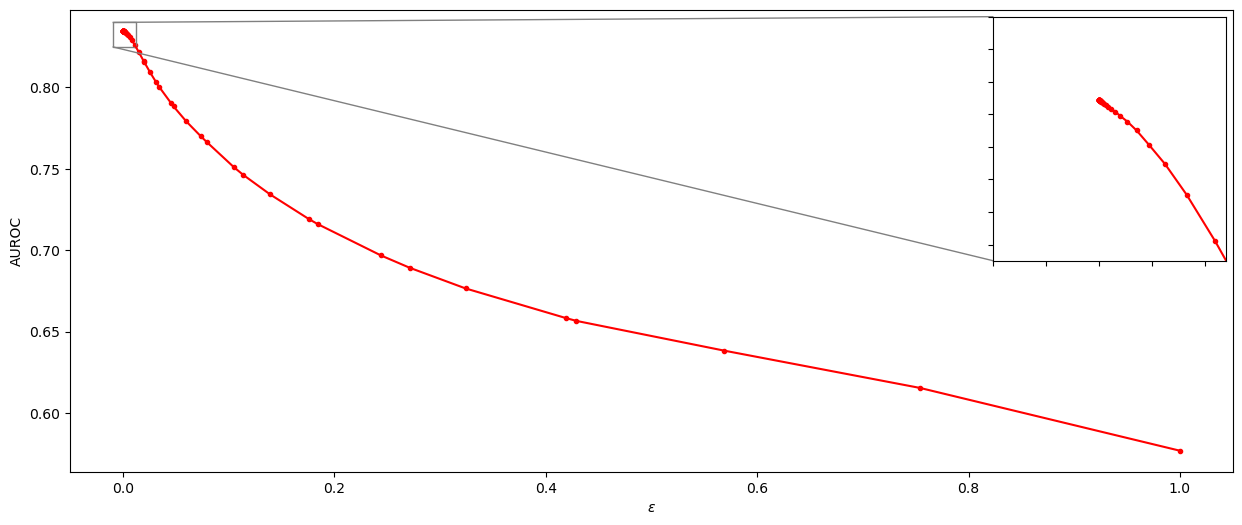

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15,6))
ax.plot(eps, aurocs, c='red')
ax.scatter(eps, aurocs, c='red', marker='.')
ax.set_xlabel('$\\epsilon$')
ax.set_ylabel('AUROC')
axins = zoomed_inset_axes(ax, 10, loc=1) # zoom = 2
axins.plot(eps, aurocs, c='red')
axins.scatter(eps, aurocs, c='red', marker='.')
axins.set_xlim(-0.01, 0.012)
axins.set_ylim(0.825, 0.84)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
plt.draw()
plt.show()
# fig.legend()

In [9]:
fn_goldfish_eps_zip_steps_0 = [fn_osr_fgsm(get_model_for_split(split_num=0, path_to_pretrained_weights_folder=root_dir + 'pretrained_weights/', device=device),
                                                tin_goldfish.to(device).detach()[None], ep, clip_range=tin_transform_range, return_step=True)
                          for ep in eps]
fn_goldfish_eps_0, fn_goldfish_eps_steps_0 = [x for x, _ in fn_goldfish_eps_zip_steps_0], [x for _, x in fn_goldfish_eps_zip_steps_0]

/Users/philip/DIKU/bachelor_project/our_modules/adv_tools.py:33: UserWarning: The operator 'aten::linalg_vector_norm' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  return fgsm(model, x, torch.zeros(len(x)), eps, lambda y_hat, y: torch.linalg.norm(y_hat, dim=-1, ord=torch.inf),


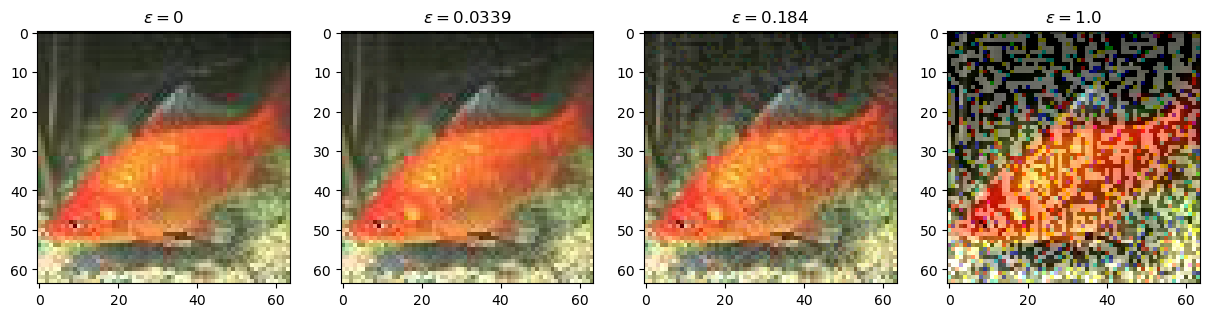

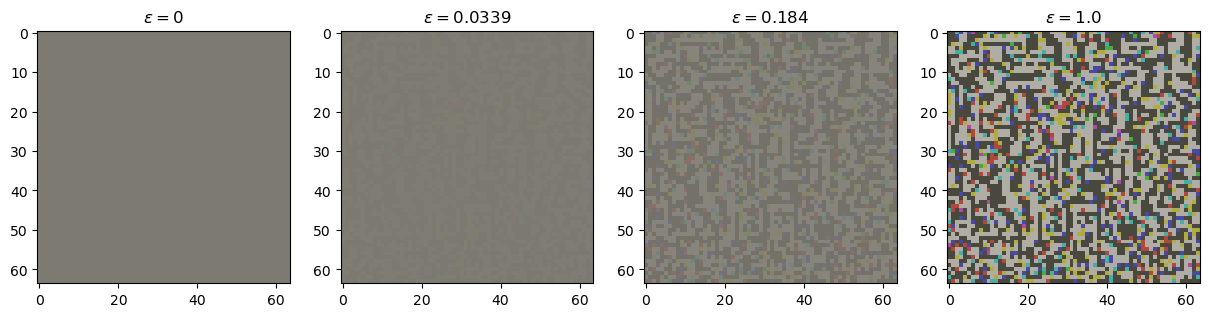

In [17]:
fig, ax = plt.subplots(1, 4, figsize = (15, 6))
eps_idxs = [39, 49, -1]
plot_image_on_ax(ax[0], tin_goldfish, mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fn_goldfish_eps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]}$")

fig, ax = plt.subplots(1, 4, figsize = (15, 6))
eps_idxs = [39, 49, -1]
plot_image_on_ax(ax[0], torch.zeros_like(tin_goldfish), mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fn_goldfish_eps_steps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]}$")
# plot_image(fn_goldfish_eps_steps_0[9][0], mean=tin_mean, std=tin_std)
# plot_image(fn_goldfish_eps_steps_0[44][0], mean=tin_mean, std=tin_std)
# plot_image(fn_goldfish_eps_steps_0[-1][0], mean=tin_mean, std=tin_std)


In [33]:
roc_stats_plain = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                      0, dataset_name='tinyimagenet', balance=True)
# roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
#                                       0, dataset_name='tinyimagenet')
roc_stats_fn = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fn/fgsm/eps_0.4192288001653537/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/fn/fgsm/eps_0.4192288001653537/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)

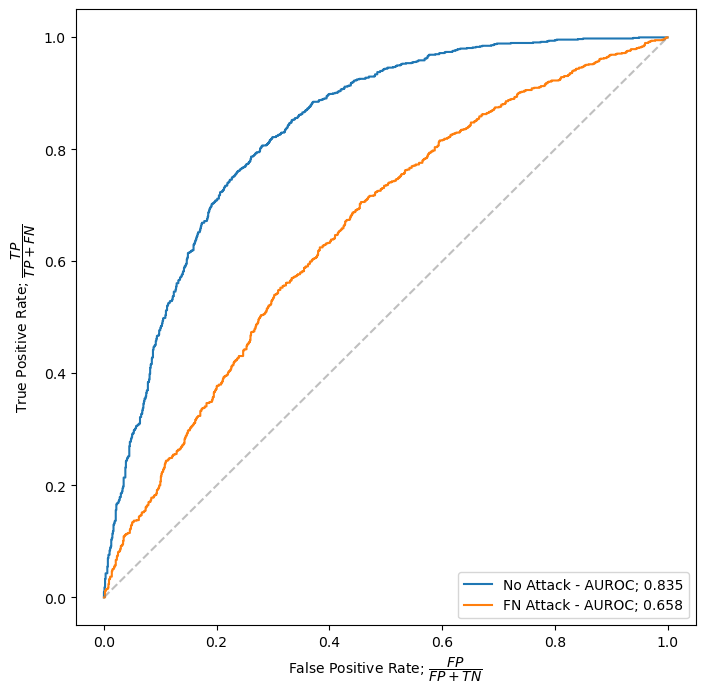

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_fn[0], label=f'FN Attack - AUROC; {roc_stats_fn[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='lower right')
plt.show()

In [44]:
id_diffs, ood_diffs = max_logit_change_compared_id_vs_ood(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                          root_dir + "logits/tinyimagenet/fn/fgsm/eps_0.11379620405527817/logits_0.pt",
                                                          root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                          0, dataset_name='tinyimagenet')

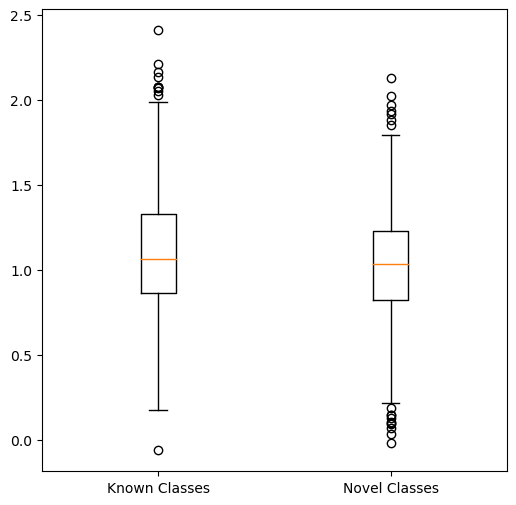

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.boxplot([id_diffs, ood_diffs[:1000]], labels=['Known Classes', 'Novel Classes'])
plt.show()